# Custom Histogram Bins Using the `breaks` Parameter

In [1]:
%use dataframe
%use @E:/Projects/JB/LPK/lets-plot-kotlin-wbb.json

In [2]:
LetsPlot.getInfo()

Lets-Plot Kotlin API v.0.0.0-SNAPSHOT. Frontend: Notebook with dynamically loaded JS. Lets-Plot JS v.4.8.0.

In [3]:
val url = "https://raw.githubusercontent.com/JetBrains/lets-plot-docs/refs/heads/master/data/diamonds.csv"
val df = DataFrame.readCSV(url)
val data = df.toMap()
println("${df.rowsCount()} x ${df.columnsCount()}")
df.head()

53940 x 10


carat,cut,color,clarity,depth,table,price,x,y,z
"0,230000",Ideal,E,SI2,"61,500000","55,000000",326,"3,950000","3,980000","2,430000"
"0,210000",Premium,E,SI1,"59,800000","61,000000",326,"3,890000","3,840000","2,310000"
"0,230000",Good,E,VS1,"56,900000","65,000000",327,"4,050000","4,070000","2,310000"
"0,290000",Premium,I,VS2,"62,400000","58,000000",334,"4,200000","4,230000","2,630000"
"0,310000",Good,J,SI2,"63,300000","58,000000",335,"4,340000","4,350000","2,750000"


## Default Bins


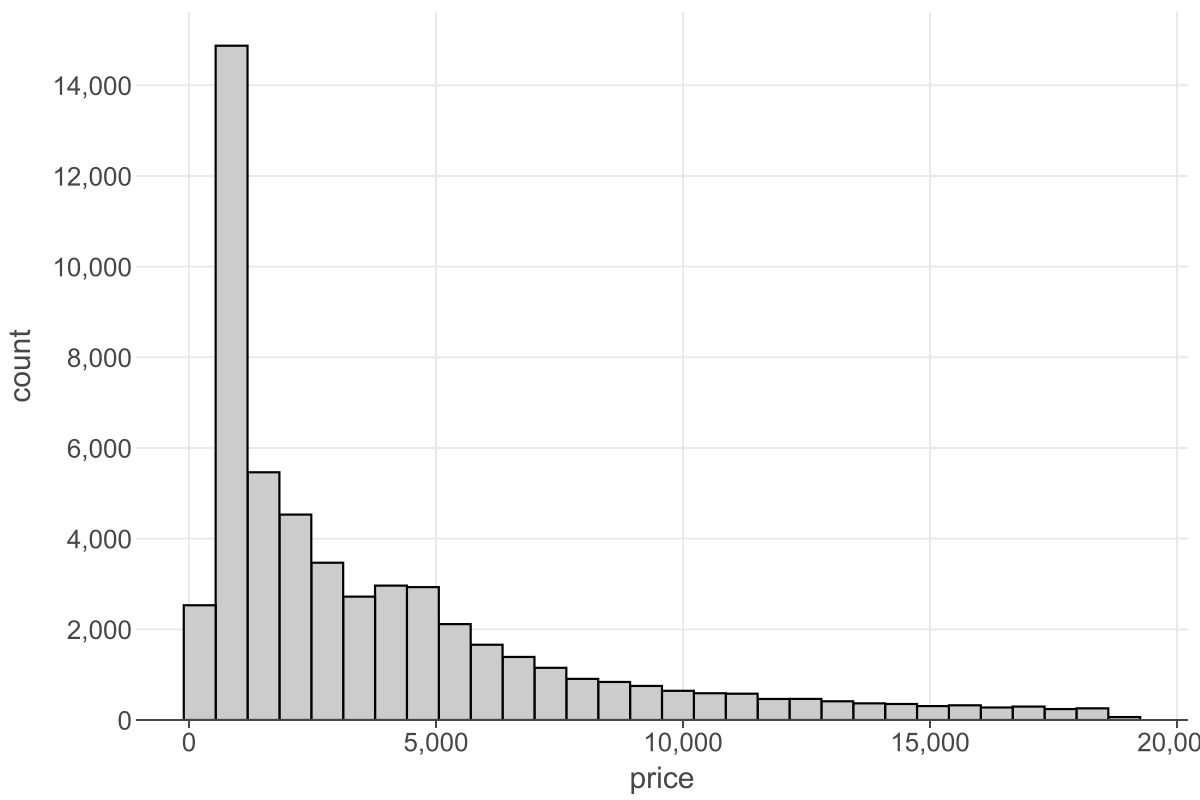

In [4]:
letsPlot(data) { x = "price" } +
    geomHistogram(color = "black", fill = "gray80")

## Equi-probable Bins


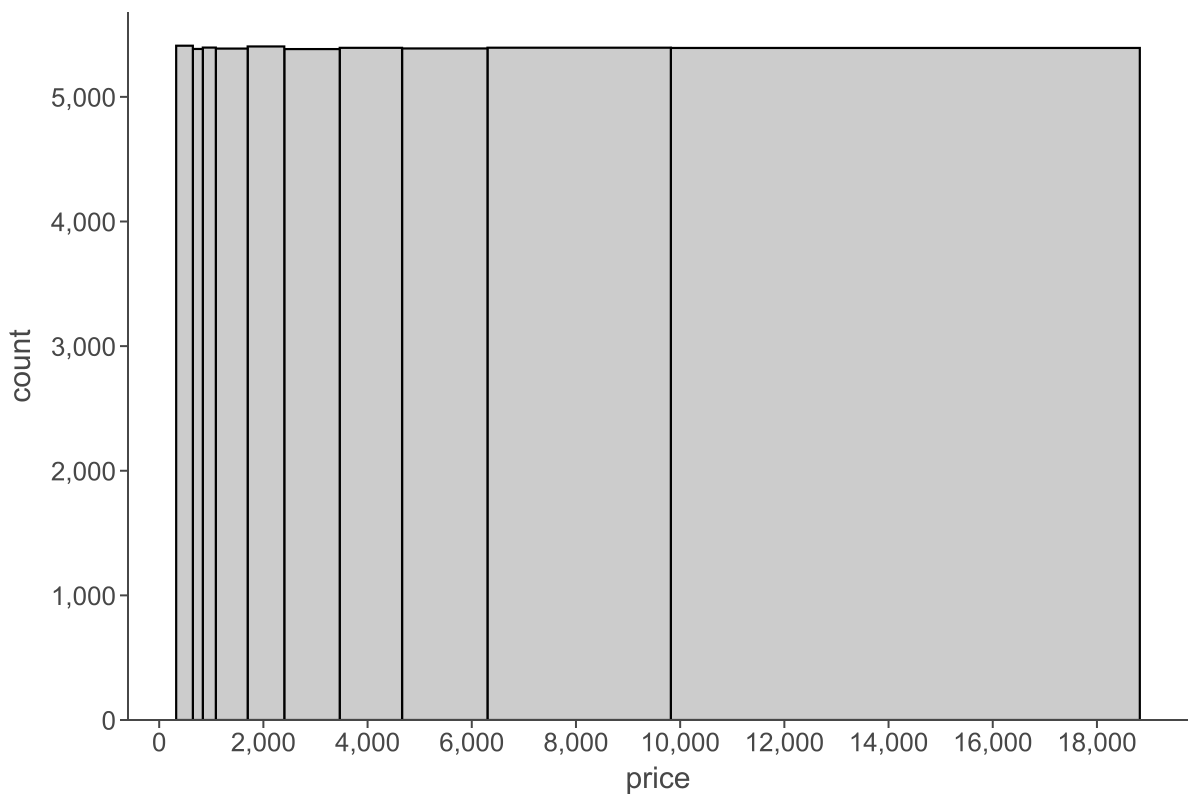

In [5]:
val prices = data["price"]
    ?.filterIsInstance<Number>()
    ?.map(Number::toDouble)
    ?.sorted()
    ?: emptyList()
    
val n = prices.size
val priceBins = (0..10).map { i ->
    val pos = i * (n - 1) / 10.0
    val lower = prices[floor(pos).toInt()]
    val upper = prices[ceil(pos).toInt()]
    lower + (upper - lower) * (pos - floor(pos))
}

letsPlot(data) { x = "price" } +
    geomHistogram(
        breaks = priceBins,
        color = "black",
        fill = "gray80"
    ) +
    themeClassic()

## Identity Stat

In [6]:
val breaks = (0..15).map { 2.0.pow(it) }
val centers = breaks.zip(breaks.drop(1)) { a, b -> (a + b) / 2.0 }

fun binCenter(v: Double?, breaks: List<Double>): Double? =
    if (v == null || v < breaks.first() || v > breaks.last()) null
    else breaks.zipWithNext().firstOrNull { (a, b) -> v >= a && v < b }?.let { (a, b) -> (a + b) / 2.0 }

val dfWithBin = df
    .convert { "price"<Number?>() }.to<Double?>()
    .add("bin_x") { binCenter(this["price"] as Double?, breaks) }   // bin center, corresponding to current price

val aggDf = dfWithBin
    .groupBy("bin_x")
    .aggregate { count() into "count" }                             // aggregated dataframe: bin center -> size of bin

aggDf

bin_x,count
"384,000000",1997
"768,000000",13008
"3072,000000",10482
"6144,000000",11608
"12288,000000",6369
"24576,000000",979
"1536,000000",9497



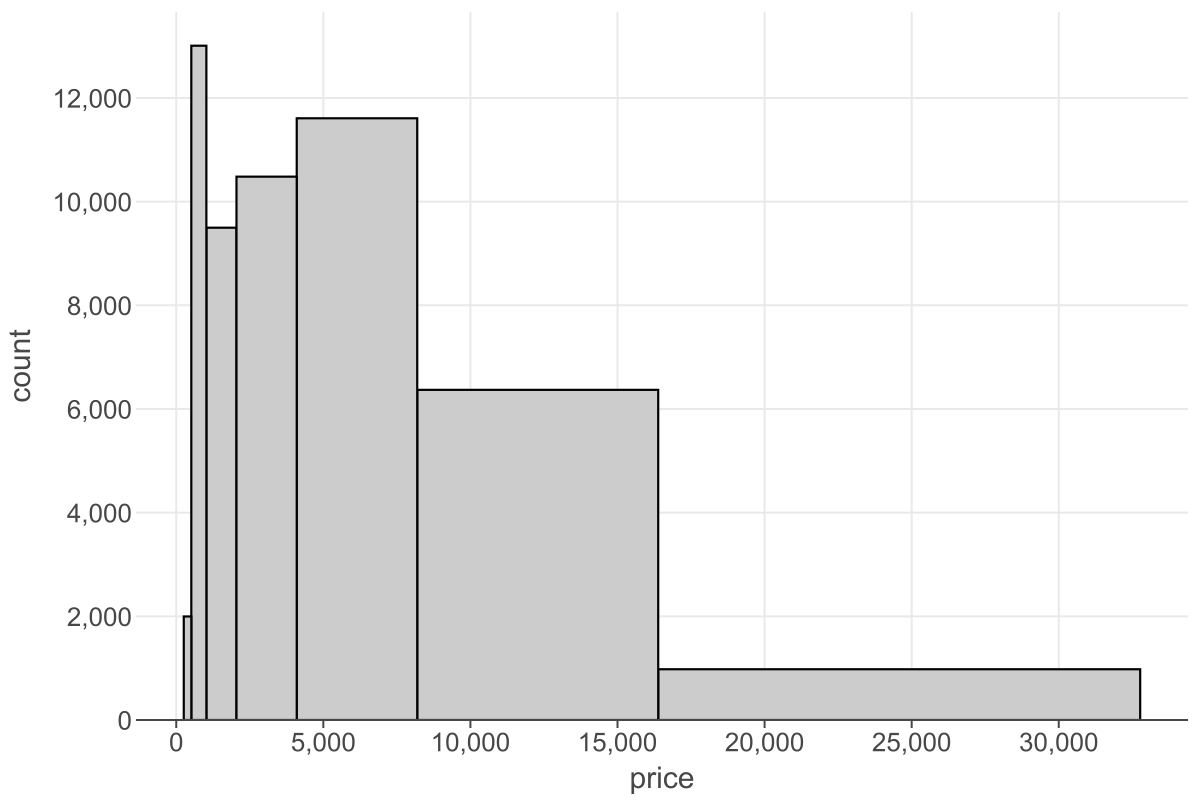

In [7]:
letsPlot(aggDf.toMap()) {
    x = "bin_x"
    y = "count"
} + geomHistogram(
    stat = Stat.identity,
    breaks = breaks,
    color = "black",
    fill = "gray80"
) + xlab("price")